# Goal
Strunturally constrained recurrent network(SCRN)
Goal is to predict the next token in the sequence given its past.

In [1]:
#import package
import numpy as np
from matplotlib import pyplot as plt
import time as time
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm

In [2]:
#data import parameter
#filename_input = "words.txt"
filename_input = "words_total.txt"
eval_steps = 2

In [3]:
#NN parameter
input_size = 26 # one-hot input of characters
s_size = 10 # size of context layer(slow)
h_size = 40 # size of hidden layer(fast)
output_size = 26 # output size, one-hot output of character
alpha = 0.95 # 0.95
num_fw = 5 # forward steps
num_bp = 50 # 50 BPTT steps
lr = 2.5 # initial learning rate
batch_size = 32
Epochs = 6000 # number of epochs
per_epoch = 100 # epochs to display loss and accuracy

In [4]:
# import data from dataset, articles or reviews
with open(filename_input) as file_input:
    data_str = file_input.read()
print('Import file: '+filename_input)


Import file: words_total.txt


In [5]:
steps = int((len(data_str)-num_fw)/num_bp/batch_size)
data_mat = np.asarray([ord(char)-ord('a') for char in data_str])

train_data_len = int((steps-eval_steps)*num_bp*batch_size)
eval_data_len = int(eval_steps*num_bp*batch_size)

train_data_mat = np.zeros([train_data_len, num_fw])
train_data_y = np.zeros([train_data_len])
eval_data_x = np.zeros([eval_data_len, num_fw])
eval_data_y = np.zeros([eval_data_len])
train_data_x = list()
train_data_y = list()
eval_data_x = list()
eval_data_y = list()

for ii in range(train_data_len):
    train_data_x.append(data_mat[ii:ii+num_fw])
    train_data_y.append(data_mat[ii+num_fw])
for ii in range(eval_data_len):
    jj = ii + train_data_len
    eval_data_x.append(data_mat[jj:jj+num_fw])
    eval_data_y.append(data_mat[jj+num_fw])

train_data_batchx = list()
train_data_batchy = list()
per_batch = int((steps-eval_steps)*num_bp)
for i in range(batch_size):
    train_data_batchx.append(train_data_x[i*per_batch: (i+1)*per_batch])
    train_data_batchy.append(train_data_y[i*per_batch: (i+1)*per_batch])

train_data_batchx = np.asarray(train_data_batchx)
train_data_batchy = np.asarray(train_data_batchy)
train_data_stepx = list()
train_data_stepy = list()
for i in range(int(steps-eval_steps)):
    train_data_stepx.append(train_data_batchx[:, i*num_bp:(i+1)*num_bp, :])
    train_data_stepy.append(train_data_batchy[:, i*num_bp:(i+1)*num_bp])

(11 steps, 32 batches, 10 bps, 5 fw)

In [6]:
# define structure of SCRN
trainX = list()
trainY = list()
for i in range(num_fw + num_bp):
    trainX.append(tf.placeholder(tf.float32, shape=(batch_size, input_size)))
for i in range(num_bp):
    trainY.append(tf.placeholder(tf.float32, shape=(batch_size, output_size)))
    
s_first = tf.placeholder(tf.float32, shape=(batch_size, s_size), name='1st_s')
h_first = tf.placeholder(tf.float32, shape=(batch_size, h_size), name='1st_h')

diag_I = np.ones([s_size]).astype('float32')
diag_Q = alpha*np.ones([s_size]).astype('float32')
I = tf.diag(diag_I, name="I")
Q = tf.diag(diag_Q, name="Q")
B = tf.Variable(tf.truncated_normal([input_size, s_size], -0.1,0.1), name='B')

P = tf.Variable(tf.truncated_normal([s_size, h_size], -0.1,0.1), name='P')
A = tf.Variable(tf.truncated_normal([input_size, h_size], -0.1,0.1), name='A')
R = tf.Variable(tf.truncated_normal([h_size, h_size], -0.1,0.1), name='R')

U = tf.Variable(tf.truncated_normal([h_size, output_size], -0.1,0.1), name='U')
V = tf.Variable(tf.truncated_normal([s_size, output_size], -0.1,0.1), name='V')


def SCRN(x, s_pre, h_pre):
    s_after = tf.matmul(x, tf.matmul(B, (I-Q))) + tf.matmul(s_pre, Q) # s_t = (I-Q)Bx_t + Qs_t-1
    h_after = tf.sigmoid(tf.matmul(s_after, P)+tf.matmul(x, A)+tf.matmul(h_pre,R)) #h_t = sigmoid(Ps_t+Ax_t+Rh_t-1)
    y_after = tf.nn.softmax(tf.matmul(h_after, U)+tf.matmul(s_after, V)) #y_t = f(Uh_t + Vs_t)
    
    return s_after, h_after, y_after


# forward
for i in range(num_bp):
    j = 0
    if i == 0:
        outputs = list()
        s_pre = s_first
        h_pre = h_first
    
    for j in range(num_fw):
        if j<num_fw-1:
            s_after, h_after, _ = SCRN(trainX[i+j], s_pre, h_pre)
        else:
            s_after, h_after,y_after = SCRN(trainX[i+j], s_pre, h_pre)
        
        
        #dropout
        s_after = tf.nn.dropout(s_after, keep_prob=0.8)
        h_after = tf.nn.dropout(h_after, keep_prob=0.9)
        
        
        s_pre = s_after
        h_pre = h_after
    
    
    outputs.append(y_after)
    

In [7]:
# train opt

#log likelihood loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tf.concat(outputs,0),labels=tf.concat(trainY,0)))
#loss = tf.losses.mean_squared_error(labels=tf.concat(trainY,0), predictions = tf.concat(outputs,0))
learning_rate = tf.placeholder(tf.float32, shape=[])

#optimizer
global_epoch = tf.Variable(0)
#learning_rate = tf.train.exponential_decay(
#    learning_rate=, global_step=global_epoch, decay_steps=5000, decay_rate=0.9, staircase=True)
#learning_rate = lr

#optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.5, use_nesterov=True)


gradients,var=zip(*optimizer.compute_gradients(loss))
gradients_clipped, _ = tf.clip_by_global_norm(gradients, 0.1)
opt=optimizer.apply_gradients(zip(gradients_clipped,var),global_step=global_epoch)

In [8]:
#add init op to the graph
init = tf.global_variables_initializer()
steps = len(train_data_stepy)

sess = tf.Session()
sess.run(init)


In [9]:
#init parameters
d_loss = 1.0
lr_ = lr
outputs_series = list()
average_loss_series = list()

In [15]:
# train SCRN
#lr_ = 0.1
#per_epoch = 100
#global_epoch = tf.Variable(0)
#Epochs = 30000
pbar = tqdm(range(Epochs))

for epoch in range(Epochs):
    feed_dict = {}
    feed_dict[learning_rate] = lr_
    
    for step in range(steps):

        average_loss = list()
        #initialize the output
        if step == 0:
            
            if epoch == 0:
                h_pass = np.zeros([batch_size, h_size], dtype=np.float32)
                s_pass = np.zeros([batch_size, s_size], dtype=np.float32)
            else:
                h_pass = np.zeros([batch_size, h_size], dtype=np.float32)
                h_pass[1:batch_size,:] = np.asarray(h_after_[0:batch_size-1,:])
                s_pass = np.zeros([batch_size, s_size], dtype=np.float32)
                s_pass[1:batch_size,:] = np.asarray(s_after_[0:batch_size-1,:])
                
            h_pass = np.zeros([batch_size, h_size], dtype=np.float32)
            s_pass = np.zeros([batch_size, s_size], dtype=np.float32)
        else:
            h_pass = h_after_
            s_pass = s_after_
        #feed_dict={h_first: h_pass, s_first:s_pass}
        feed_dict[h_first] = h_pass
        feed_dict[s_first] = s_pass

#11 steps, 32 batches, 10 bp, 5 fw
        #trains x
        for i in range(num_bp+num_fw):
            if i <num_bp-1:
                batch_x_i = train_data_stepx[step][:,i,0].astype(int)
            else:
                batch_x_i = train_data_stepx[step][:,num_bp-1,i-num_bp].astype(int)
            batch_x_i.reshape([batch_size,1])
            batch_x_i_onehot = np.zeros((len(batch_x_i), input_size))
            batch_x_i_onehot[range(len(batch_x_i)), batch_x_i] = 1
            feed_dict[trainX[i]] = batch_x_i_onehot
            
        for i in range(num_bp):
            batch_y_i = train_data_stepy[step][:,i].astype(int)
            batch_y_i.reshape([batch_size,1])
            batch_y_i_onehot = np.zeros((len(batch_y_i), output_size))
            batch_y_i_onehot[range(len(batch_y_i)), batch_y_i]=1
            feed_dict[trainY[i]] = batch_y_i_onehot

        #feed_dict[learning_rate] = 0.1

        h_after_, s_after_, l ,outputs_, opt_ = sess.run([h_after, s_after, loss, outputs, opt], feed_dict=feed_dict)
        outputs_series.append(outputs_)
        average_loss.append(l)
        ave_loss = sum(average_loss)/float(len(average_loss))

        
    pbar.update(1)

    #average_loss_series.append(ave_loss)
    global_epoch += 1
    if epoch%per_epoch == 0:
        average_loss_series.append(ave_loss)
        
        if len(average_loss_series) == 1:
            d_loss = average_loss_series[0]
            ave_loss_pre = ave_loss
        else:
            #d_loss = average_loss_series[-1] - average_loss_series[-2]
            d_loss = ave_loss_pre - ave_loss
            ave_loss_pre = ave_loss
        
        
        if np.abs(d_loss)<1.0e-3:
            lr_ = lr_/1.5
        
        
        print('Epoch: '+str(epoch)+ ' Average Loss: ' +str(ave_loss) + ' Learning Rate: ' +str(lr_))
    #if ave_loss<0.8:
    #    break
pbar.close()

A Jupyter Widget

Epoch: 0 Average Loss: 3.12016320229 Learning Rate: 0.7407407407407408



Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\Lixiang\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\users\lixiang\src\tqdm\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Lixiang\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Epoch: 100 Average Loss: 3.1179921627 Learning Rate: 0.7407407407407408
Epoch: 200 Average Loss: 3.11793518066 Learning Rate: 0.4938271604938272
Epoch: 300 Average Loss: 3.11956453323 Learning Rate: 0.4938271604938272
Epoch: 400 Average Loss: 3.11596703529 Learning Rate: 0.4938271604938272
Epoch: 500 Average Loss: 3.11708426476 Learning Rate: 0.4938271604938272
Epoch: 600 Average Loss: 3.11567378044 Learning Rate: 0.4938271604938272
Epoch: 700 Average Loss: 3.11223363876 Learning Rate: 0.4938271604938272
Epoch: 800 Average Loss: 3.11515450478 Learning Rate: 0.4938271604938272
Epoch: 900 Average Loss: 3.11761927605 Learning Rate: 0.4938271604938272


KeyboardInterrupt: 

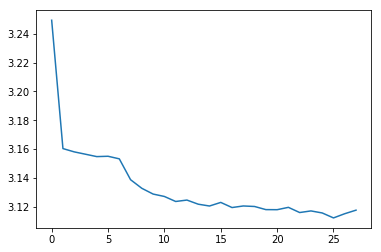

In [16]:
# plot tuning curve
f1 = plt.figure()
plt.plot(average_loss_series)
plt.show(f1)

In [17]:
# predict and evaluate
def eval_(data_x=eval_data_x, data_y=eval_data_y, num_fw=num_fw):
    evalX=[]
    y_ = []
    char_= list()
    for ii in range(num_fw):
        evalX.append(tf.placeholder(tf.float32, shape=(1, input_size)))
    
    s_first_eval = tf.placeholder(tf.float32, shape=(1, s_size), name='1st_s_eval')
    h_first_eval = tf.placeholder(tf.float32, shape=(1, h_size), name='1st_h_eval')
    
    for j in range(num_fw):
        if j<num_fw-1:
            s_after_eval, h_after_eval, _ = SCRN(evalX[j], s_first_eval, h_first_eval)
        else:
            s_after_eval, h_after_eval,y_after_eval = SCRN(evalX[j], s_pre_eval, h_pre_eval)
        s_pre_eval = s_after_eval
        h_pre_eval = h_after_eval
    outputs_eval = tf.argmax(y_after_eval)
    
    acc_eva = 0
    for step in range(len(data_y)):
        #feed dictory
        if step == 0:
            h_pass_eval = np.zeros([1, h_size], dtype=np.float32)
            s_pass_eval = np.zeros([1, s_size], dtype=np.float32)
        else:
            h_pass_eval = h_after_eval_
            s_pass_eval = s_after_eval_
        feed_dict_eval={h_first_eval: h_pass_eval, s_first_eval:s_pass_eval}
        for ii in range(num_fw):
            data_x_i = data_x[step][ii].reshape([1])
            data_x_i_onehot = np.zeros([1,input_size])
            #print(step, ii, data_x_i)
            data_x_i_onehot[range(1),data_x_i] = 1
            feed_dict_eval[evalX[ii]] = data_x_i_onehot
            
        h_after_eval_, s_after_eval_, outputs_eval_, y_after_eval_= sess.run(
            [h_after_eval, s_after_eval, outputs_eval, y_after_eval], feed_dict=feed_dict_eval)
        
        y_.append(chr(np.argmax(y_after_eval_)+ord('a')))
        
        if np.argmax(y_after_eval_) == data_y[step].reshape([]):
            acc_eva += 1
            #print(y_[-1],chr(data_y[step]+ord('a')))
            char_.append(y_[-1])
    
    print('List of successfully recalled characters: %s' %(list(set(char_))))
    acc = acc_eva/len(data_y)
    print('Accuracy: %f'%(acc))
    return acc

In [18]:
acc =eval_()

List of successfully recalled characters: ['o', 't', 'e', 'r']
Accuracy: 0.200937


In [ ]:
# results(generate a paper? recall the memory?)
